# Classification of UCF11 dataset using the pre-trained CrossModal VideoMAE model
## Fine-tuning the model on the UCF11 dataset training set and evaluating on the test set

In [6]:
# Standard Libraries
import os
import sys
from collections import defaultdict
import yaml

# Data Manipulation Libraries
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# PyTorch Libraries
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

# Machine Learning Utilities
from sklearn.model_selection import train_test_split

# Progress Bar
from tqdm import tqdm

#set project root
project_root = '/home/ndelafuente/VD-MAE'

# DepthAnythingV2 (Ensure the path is correct)
sys.path.append(os.path.join(project_root, 'depth_anything_v2'))
from depth_anything_v2.dpt import DepthAnythingV2

# Custom Modules
sys.path.append(os.path.join(project_root, 'utils'))
from tubeletembed import TubeletEmbed

sys.path.append(os.path.join(project_root, 'models'))
from videomae_cross_modal import CrossModalVideoMAE

sys.path.append(os.path.join(project_root, 'data'))
from dataloader import VideoFrameDataset

# Load model config and instantiate
config_path = os.path.join(project_root, 'config/config.yaml')
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)



/home/ndelafuente/miniconda3/envs/vdmae/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ndelafuente/miniconda3/envs/vdmae/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [7]:
#Device assignment

depth_device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
encoder_device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
classification_head_device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')


Initialize depth model

In [8]:

# Define the configuration for DepthAnythingV2
depth_model_config = {
    'encoder': 'vitl',          # Example parameter, adjust based on your implementation
    'features': 256,
    'out_channels': [256, 512, 1024, 1024]
}


# Initialize the DepthAnythingV2 model
depth_model = DepthAnythingV2(**depth_model_config)

# Move the model to the appropriate device
depth_model = depth_model.to(depth_device)

# Set the model to evaluation mode since we're generating Depth maps on the fly
depth_model.eval()

# Load pretrained weights for DepthAnythingV2
depth_model_checkpoint = config['data']['depth_model_checkpoint']
depth_model.load_state_dict(torch.load(depth_model_checkpoint, map_location=depth_device))
print("DepthAnythingV2 model loaded successfully.")


/tmp/ipykernel_1742727/2454183609.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  depth_model.load_state_dict(torch.load(depth_model_checkpoint, map_location=depth_devi

DepthAnythingV2 model loaded successfully.


Dataloading

In [9]:
from collections import defaultdict
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

# Define the root directory of the dataset
root_dir = '/data/datasets/ucf11/UCF11_updated_mpg'

# Create a mapping from label names to integers
label_names = sorted([name for name in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, name))])
label_to_index = {label: idx for idx, label in enumerate(label_names)}
index_to_label = {idx: label for label, idx in label_to_index.items()}

class UCF11Dataset(Dataset):
    def __init__(self, root_dir, transform=None, num_frames=16, resize_dim=(224, 224), label_mapping=None, depth_model=None):
        self.root_dir = root_dir
        self.transform = transform
        self.num_frames = num_frames
        self.resize_dim = resize_dim
        self.videos = []
        self.labels = []
        self.label_mapping = label_mapping if label_mapping else {}
        self.depth_model = depth_model  # Depth estimation model

        # Traverse the directory structure and load video paths and labels
        for label_folder in os.listdir(root_dir):
            label_path = os.path.join(root_dir, label_folder)
            if os.path.isdir(label_path):
                for subfolder in os.listdir(label_path):
                    subfolder_path = os.path.join(label_path, subfolder)
                    if os.path.isdir(subfolder_path):
                        for video_file in os.listdir(subfolder_path):
                            if video_file.endswith((".mpg", ".mp4", ".avi", ".mov")):
                                video_path = os.path.join(subfolder_path, video_file)
                                self.videos.append(video_path)
                                self.labels.append(label_mapping[label_folder])  # Map label to index

        print(f"Found {len(self.videos)} videos with {len(set(self.labels))} unique labels.")

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        video_path = self.videos[idx]
        label = self.labels[idx]

        # Load video frames as a list of PIL images
        cap = cv2.VideoCapture(video_path)
        frames = []
        success, frame = cap.read()

        while success and len(frames) < self.num_frames:
            frame = cv2.resize(frame, self.resize_dim)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = Image.fromarray(frame)
            if self.transform:
                frame = self.transform(frame)
            frames.append(frame)
            success, frame = cap.read()
        cap.release()

        # Ensure a fixed number of frames by sampling or padding
        if len(frames) > self.num_frames:
            frames = frames[:self.num_frames]
        elif len(frames) < self.num_frames and len(frames) > 0:
            frames = frames * (self.num_frames // len(frames)) + frames[:self.num_frames % len(frames)]
        elif len(frames) == 0:
            frames = [torch.zeros(3, *self.resize_dim) for _ in range(self.num_frames)]

        # Convert list of frames to tensor [T, 3, H, W]
        frames = torch.stack(frames)  # Shape: [T, 3, H, W]

        # Depth estimation
        if self.depth_model is not None:
            with torch.no_grad():
                # Reshape to [T, 3, H, W] for batch processing
                frames_flat = frames.to(encoder_device)  # Already [T, 3, H, W]
                # Generate Depth maps
                depth_maps_flat = self.depth_model(frames_flat).cpu()  # Assume output shape [T, 1, H, W]
            # Reshape to [1, T, H, W]
            depth_maps = depth_maps_flat.unsqueeze(0)  # [1, T, H, W]
            #print(f"Generated Depth Maps Shape: {depth_maps.shape}")
        else:
            depth_maps = torch.zeros(1, self.num_frames, *self.resize_dim).to(encoder_device)
            print("Depth model not provided. Using zero tensors for Depth maps.")

        # Permute frames to [3, T, H, W]
        frames = frames.permute(1, 0, 2, 3)  # [3, T, H, W]
        #print(f"Permuted Frames Shape: {frames.shape}")
        #print(f"Permuted Depth Maps Shape: {depth_maps.shape}")

        return frames, depth_maps, label  # [3, T, H, W], [1, T, H, W], label


In [10]:

# Initialize the UCF11Dataset with label mapping and depth_model
ucf11_dataset = UCF11Dataset(
    root_dir=root_dir,
    transform=transforms.Compose([
        transforms.ToTensor(),  # Convert PIL images to tensors
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                             std=[0.229, 0.224, 0.225])   # ImageNet std
    ]),
    label_mapping=label_to_index,
    depth_model=depth_model  # Pass the initialized Depth model
)

# Split indices for train and validation sets
train_indices, val_indices = train_test_split(
    range(len(ucf11_dataset)),
    test_size=0.2,
    stratify=ucf11_dataset.labels,
    random_state=42
)

# Create training and validation subsets
train_dataset = Subset(ucf11_dataset, train_indices)
val_dataset = Subset(ucf11_dataset, val_indices)

# Define DataLoaders for training and validation
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=0,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=0,
)

# Example iteration over the train and validation DataLoader
print("Training DataLoader:")
for frames, depth_maps, labels in train_loader:
    print(f'Frames batch size: {frames.size()}')         # Expected: [16, 3, 16, 224, 224]
    print(f'Depth Maps batch size: {depth_maps.size()}') # Expected: [16, 1, 16, 224, 224]
    print(f'Labels batch: {labels}')                    # Expected: tensor of shape [16]
    break  # Break for demonstration

print("\nValidation DataLoader:")
for frames, depth_maps, labels in val_loader:
    print(f'Frames batch size: {frames.size()}')         # Expected: [16, 3, 16, 224, 224]
    print(f'Depth Maps batch size: {depth_maps.size()}') # Expected: [16, 1, 16, 224, 224]
    print(f'Labels batch: {labels}')                    # Expected: tensor of shape [16]
    break  # Break for demonstration




Found 1600 videos with 11 unique labels.
Training DataLoader:
Frames batch size: torch.Size([16, 3, 16, 224, 224])
Depth Maps batch size: torch.Size([16, 1, 16, 224, 224])
Labels batch: tensor([4, 3, 1, 5, 1, 3, 2, 1, 5, 5, 2, 8, 0, 5, 2, 3])

Validation DataLoader:
Frames batch size: torch.Size([16, 3, 16, 224, 224])
Depth Maps batch size: torch.Size([16, 1, 16, 224, 224])
Labels batch: tensor([1, 0, 7, 9, 3, 8, 3, 7, 7, 6, 2, 9, 1, 5, 1, 5])


Visualize batch

Visualizing Class: basketball
 - RGB Frame Shape: (224, 224, 3)
 - Depth Map Shape: (224, 224)
Visualizing Class: biking
 - RGB Frame Shape: (224, 224, 3)
 - Depth Map Shape: (224, 224)
Visualizing Class: diving
 - RGB Frame Shape: (224, 224, 3)
 - Depth Map Shape: (224, 224)
Visualizing Class: golf_swing
 - RGB Frame Shape: (224, 224, 3)
 - Depth Map Shape: (224, 224)
Visualizing Class: horse_riding
 - RGB Frame Shape: (224, 224, 3)
 - Depth Map Shape: (224, 224)
Visualizing Class: soccer_juggling
 - RGB Frame Shape: (224, 224, 3)
 - Depth Map Shape: (224, 224)
Visualizing Class: swing
 - RGB Frame Shape: (224, 224, 3)
 - Depth Map Shape: (224, 224)
Visualizing Class: tennis_swing
 - RGB Frame Shape: (224, 224, 3)
 - Depth Map Shape: (224, 224)
Visualizing Class: trampoline_jumping
 - RGB Frame Shape: (224, 224, 3)
 - Depth Map Shape: (224, 224)
Visualizing Class: volleyball_spiking
 - RGB Frame Shape: (224, 224, 3)
 - Depth Map Shape: (224, 224)
Visualizing Class: walking
 - RGB Fram

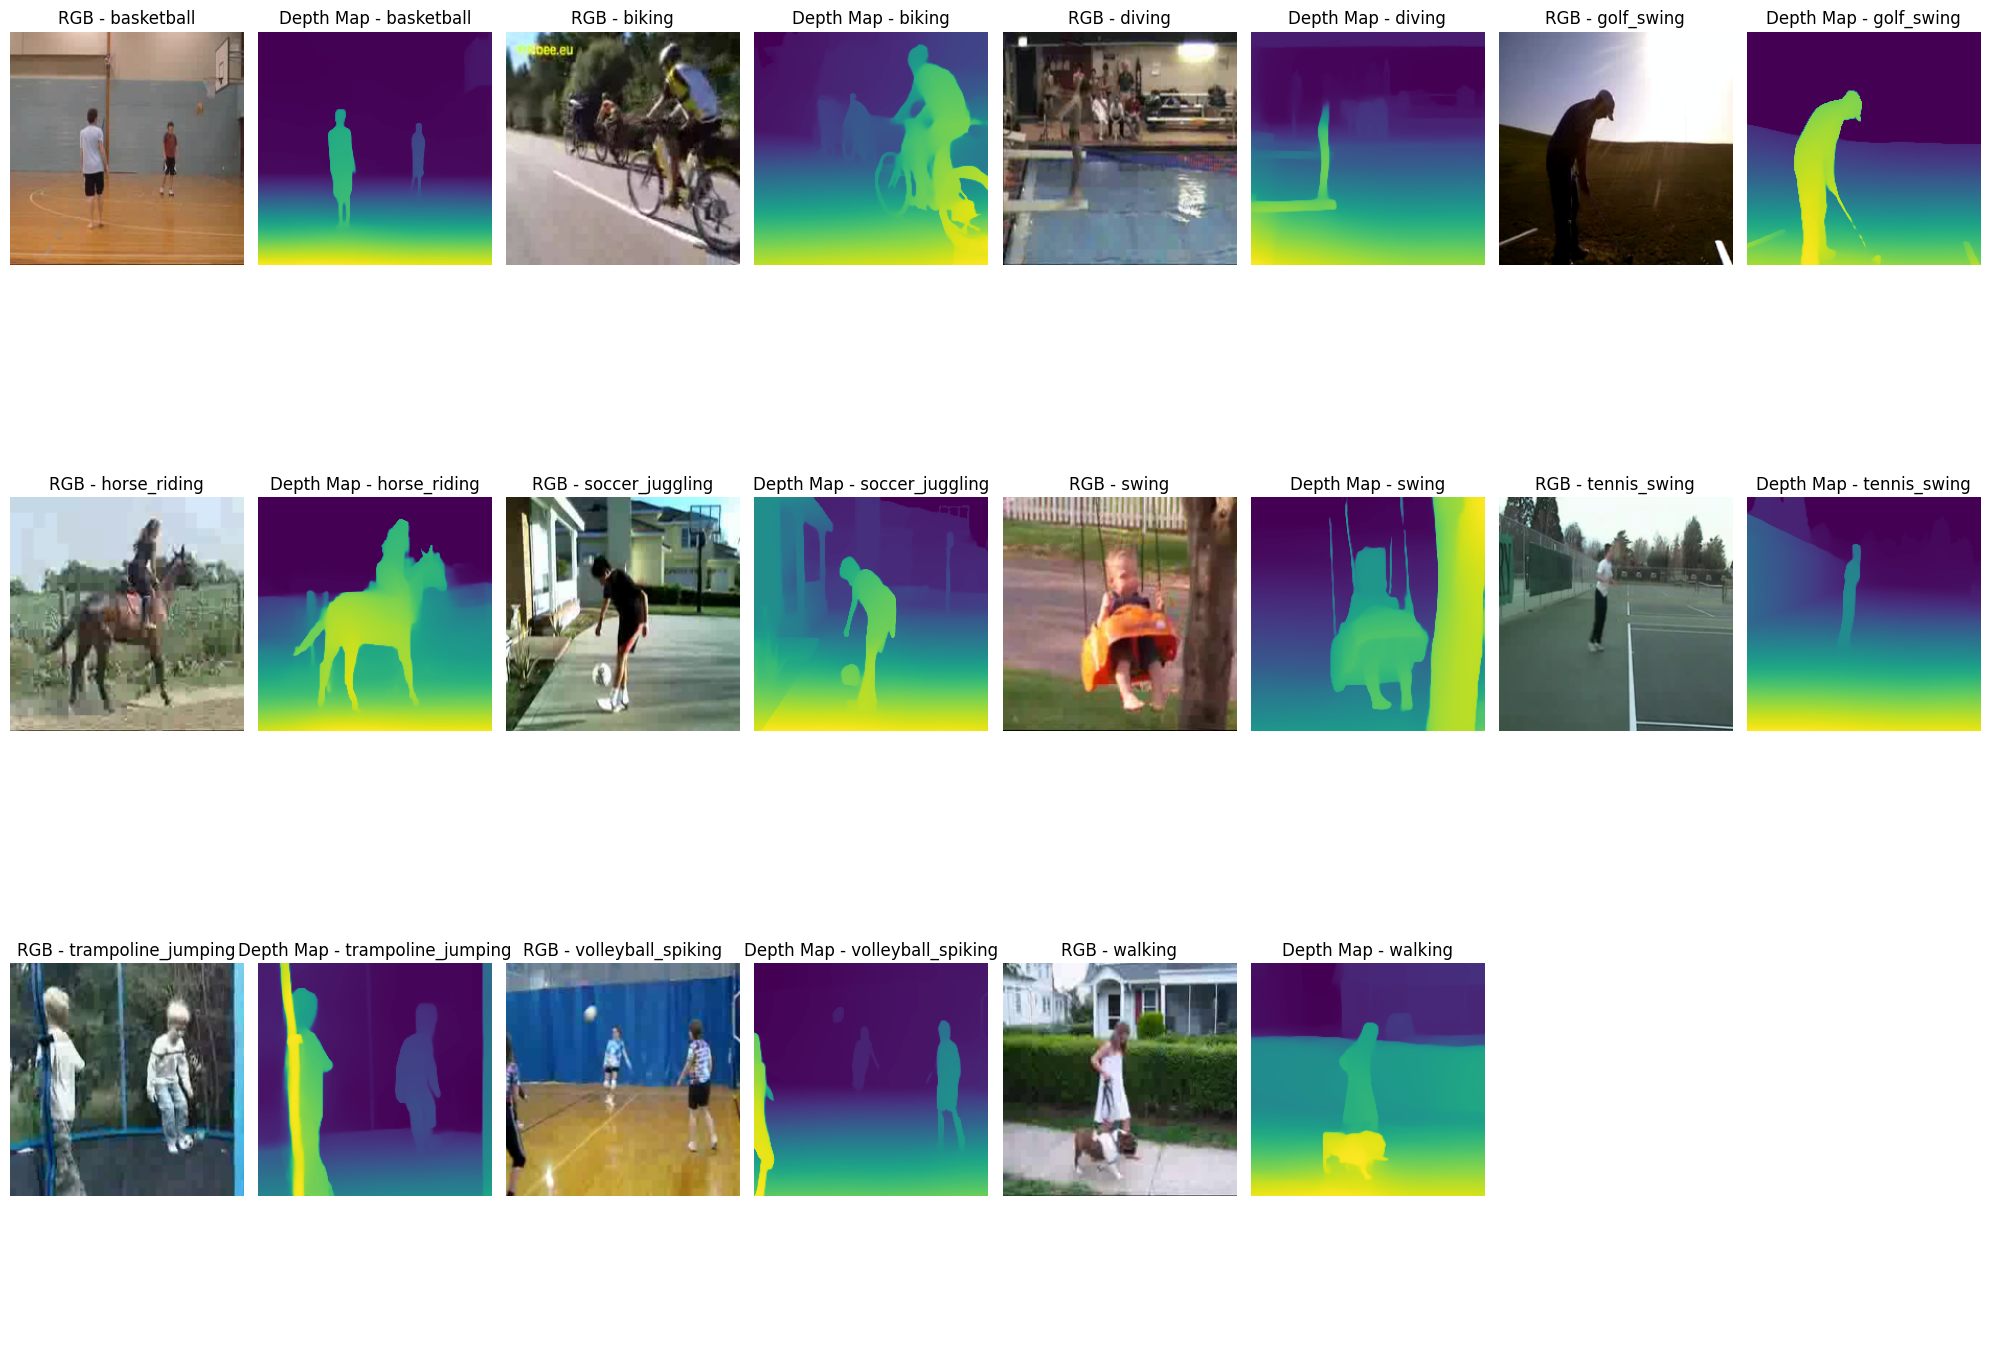

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import math
import torch

# Mean and std for unnormalization
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Collect one example per class
class_examples = {}

for idx in range(len(ucf11_dataset)):
    label = ucf11_dataset.labels[idx]
    if label not in class_examples:
        class_examples[label] = idx
    if len(class_examples) == len(label_names):
        break

# Plot the first frame and its Depth map of each example in a grid
num_classes = len(class_examples)
cols = 4  # Number of columns in the grid (each class has 2 plots: RGB and Depth)
rows = math.ceil(num_classes / cols)

# Create subplots: 2 columns per class (RGB and Depth)
fig, axes = plt.subplots(rows, cols * 2, figsize=(20, 5 * rows))
axes = np.atleast_2d(axes)  # Ensure axes is 2D

for idx, (label, video_idx) in enumerate(sorted(class_examples.items())):
    row = idx // cols
    col = idx % cols

    ax_rgb = axes[row, col * 2]
    ax_depth = axes[row, col * 2 + 1]
    
    frames, depth_maps, label_idx = ucf11_dataset[video_idx]
    
    # Select the first frame and its Depth map
    frame = frames[:, 0, :, :].cpu().numpy()        # [3, H, W]
    depth_map = depth_maps[:, 0, :, :].cpu().numpy()  # [1, H, W]
    
    # Unnormalize the frame
    frame = frame.transpose(1, 2, 0)                # [H, W, 3]
    frame = frame * std + mean
    frame = np.clip(frame, 0, 1)
    
    # Squeeze depth map to [H, W]
    depth_map = depth_map.squeeze()                 # [H, W]
    
    # Debugging Prints
    print(f"Visualizing Class: {index_to_label[label]}")
    print(f" - RGB Frame Shape: {frame.shape}")
    print(f" - Depth Map Shape: {depth_map.shape}")
    
    # Display RGB Frame
    ax_rgb.imshow(frame)
    ax_rgb.set_title(f"RGB - {index_to_label[label]}")
    ax_rgb.axis('off')
    
    # Display Depth Map
    ax_depth.imshow(depth_map, cmap='viridis')
    ax_depth.set_title(f"Depth Map - {index_to_label[label]}")
    ax_depth.axis('off')

# Hide any unused subplots
total_plots = rows * cols * 2
used_plots = num_classes * 2
for i in range(used_plots, total_plots):
    row = i // (cols * 2)
    col = i % (cols * 2)
    axes.flat[i].axis('off')

plt.tight_layout()
plt.show()


Load pretrained model

In [ ]:
# Load the model with config
model = CrossModalVideoMAE(config['model'])
checkpoint_path = '/home/ndelafuente/VD-MAE/checkpoints/model_at_epoch_x.pth'

# Load the checkpoint
checkpoint = torch.load(checkpoint_path, map_location=encoder_device)

# Remove "module." prefix from keys
state_dict = checkpoint['model_state_dict']
new_state_dict = {}
for key, value in state_dict.items():
    new_key = key.replace("module.", "")  # Remove "module." prefix
    new_state_dict[new_key] = value

# Load the adjusted state dict
model.load_state_dict(new_state_dict)
model.to(encoder_device)


Number of tubelets: 6272
Number of tubelets: 6272


/tmp/ipykernel_1742727/2770204509.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=encoder_device)


We're only interested in the encoder for this task

In [8]:
import torch.nn as nn

class EncoderForFinetuning(nn.Module):
    def __init__(self, full_model):
        super(EncoderForFinetuning, self).__init__()
        # Copy over the specific encoder layers
        self.rgb_tubelet_embed = full_model.rgb_tubelet_embed
        self.depth_tubelet_embed = full_model.depth_tubelet_embed
        self.encoder_blocks = full_model.encoder  # This is a ModuleList of blocks
        self.encoder_norm = full_model.encoder_norm

    def forward(self, rgb_frames, depth_maps):
        # Pass RGB and Depth frames through tubelet embeddings
        rgb_embed = self.rgb_tubelet_embed(rgb_frames)
        depth_embed = self.depth_tubelet_embed(depth_maps)
        combined = rgb_embed + depth_embed

        # Iterate through encoder blocks
        for block in self.encoder_blocks:
            combined = block(combined)

        # Apply final layer normalization
        encoded_output = self.encoder_norm(combined)
        return encoded_output

# Initialize the encoder for fine-tuning
encoder = EncoderForFinetuning(model).to(encoder_device)
print("Encoder:")
print(encoder)

Encoder:
EncoderForFinetuning(
  (rgb_tubelet_embed): TubeletEmbed(
    (proj): Conv3d(3, 768, kernel_size=(1, 16, 16), stride=(1, 16, 16))
  )
  (depth_tubelet_embed): TubeletEmbed(
    (proj): Conv3d(1, 768, kernel_size=(1, 16, 16), stride=(1, 16, 16))
  )
  (encoder_blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, in

Add a classification head to the model


In [9]:
import torch.nn as nn

# Define the number of classes in UCF11
num_classes = len(set(train_dataset.dataset.labels))
print(f"Number of classes: {num_classes}")

# Create the classification head
# Assuming the encoder outputs 768-dimensional features
classification_head = nn.Linear(in_features=768, out_features=num_classes)

# Initialize the classification head
nn.init.xavier_uniform_(classification_head.weight)
if classification_head.bias is not None:
    nn.init.zeros_(classification_head.bias)

# Move the classification head to the device
classification_head = classification_head.to(classification_head_device)

# Print the classification head to verify
print("Classification Head:")
print(classification_head)

Number of classes: 11
Classification Head:
Linear(in_features=768, out_features=11, bias=True)


Set up the optimizer and loss function

In [10]:
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
learning_rate = 1e-4  # Starting learning rate for fine-tuning
weight_decay = 1e-5   # Helps prevent overfitting

# Include parameters from both the encoder and classification head
optimizer = optim.Adam(
    list(encoder.parameters()) + list(classification_head.parameters()),
    lr=learning_rate,
    weight_decay=weight_decay
)

#Print the optimizer to verify
print("Optimizer:")
print(optimizer)
print("\nWhat's optimized:")
print("from the CrossModalVideoMAE encoder:")
for name, param in encoder.named_parameters():
    if param.requires_grad:
        print(name)
print("\nfrom the Classification Head:")
for name, param in classification_head.named_parameters():
    if param.requires_grad:
        print(name)

# Define a learning rate scheduler
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)  # Decays LR by 0.1 every 3 epochs

Optimizer:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 1e-05
)

What's optimized:
from the CrossModalVideoMAE encoder:
rgb_tubelet_embed.proj.weight
rgb_tubelet_embed.proj.bias
depth_tubelet_embed.proj.weight
depth_tubelet_embed.proj.bias
encoder_blocks.0.norm1.weight
encoder_blocks.0.norm1.bias
encoder_blocks.0.attn.qkv.weight
encoder_blocks.0.attn.qkv.bias
encoder_blocks.0.attn.proj.weight
encoder_blocks.0.attn.proj.bias
encoder_blocks.0.norm2.weight
encoder_blocks.0.norm2.bias
encoder_blocks.0.mlp.fc1.weight
encoder_blocks.0.mlp.fc1.bias
encoder_blocks.0.mlp.fc2.weight
encoder_blocks.0.mlp.fc2.bias
encoder_blocks.1.norm1.weight
encoder_blocks.1.norm1.bias
encoder_blocks.1.attn.qkv.weight
encoder_blocks.1.attn.qkv.bias
encoder_blocks.1.attn.proj.weight
encoder_blocks.1.attn.proj.bias
encoder_blocks.1.norm2.weight

Defining the Training Loop

In [11]:
# ## Implement the Training and Validation Loops


from tqdm import tqdm

#Create a txt file for logging losses and accuracies
log_file = open("log.txt", "w")


#empty cuda cache
torch.cuda.empty_cache()

# Define DataLoaders for training and validation
train_loader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=0,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
)


# Define the number of epochs for fine-tuning
num_epochs = 10

finetuning_encoder = True


# Initialize lists to store loss and accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Initialize best validation accuracy
best_val_acc = 0.0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    print("-" * 30)
    
    # ==================== Training Phase ====================
    # Set the encoder to training mode only if we're fine-tuning the encoder
    if finetuning_encoder:
        encoder.train() # Set encoder to evaluation mode if it has any dropout or batchnorm layers that behave differently
    else:
        encoder.eval()    
    
    classification_head.train()  # Set classification head to training mode

    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch_idx, (frames, depth_maps, labels) in enumerate(tqdm(train_loader, desc="Training")):
        # Move data to device
        frames = frames.to(encoder_device)          # Shape: [B, 3, T, H, W]
        depth_maps = depth_maps.to(depth_device)  # Shape: [B, 1, T, H, W]
        labels = labels.to(classification_head_device)          # Shape: [B]

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass through the encoder
        encoder_output = encoder(frames, depth_maps)  # Shape: [B, N, 768]

        # Pool the encoder output (e.g., average pooling across the tubelet dimension)
        pooled_output = encoder_output.mean(dim=1)   # Shape: [B, 768]

        # Forward pass through the classification head
        class_logits = classification_head(pooled_output)  # Shape: [B, num_classes]

        # Compute loss
        loss = criterion(class_logits, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item() * frames.size(0)

        # Compute accuracy
        _, preds = torch.max(class_logits, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

        # Optional: Print batch loss every 10 batches
        if (batch_idx + 1) % 10 == 0:
            print(f"Batch {batch_idx + 1}/{len(train_loader)} - Loss: {loss.item():.4f}")
            # Write to log file
            log_file.write(f"\tBatch {batch_idx + 1}/{len(train_loader)} - Loss: {loss.item():.4f}\n")


    epoch_loss = running_loss / total_train
    epoch_acc = correct_train / total_train
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Training Loss: {epoch_loss:.4f} | Training Accuracy: {epoch_acc:.4f}")
    log_file.write(f"Epoch {epoch} Training Loss: {epoch_loss:.4f} | Epoch {epoch} Training Accuracy: {epoch_acc:.4f}\n")


    # ==================== Validation Phase ====================
    encoder.eval()  # Set encoder to evaluation mode
    classification_head.eval()  # Set classification head to evaluation mode

    running_loss_val = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for batch_idx, (frames, depth_maps, labels) in enumerate(tqdm(val_loader, desc="Validation")):
            # Move data to device
            frames = frames.to(encoder_device)          # Shape: [B, 3, T, H, W]
            depth_maps = depth_maps.to(depth_device)  # Shape: [B, 1, T, H, W]
            labels = labels.to(classification_head_device)          # Shape: [B]

            # Forward pass through the encoder
            encoder_output = encoder(frames, depth_maps)  # Shape: [B, N, 768]

            # Pool the encoder output
            pooled_output = encoder_output.mean(dim=1)   # Shape: [B, 768]

            # Forward pass through the classification head
            class_logits = classification_head(pooled_output)  # Shape: [B, num_classes]

            # Compute loss
            loss = criterion(class_logits, labels)

            # Update running loss
            running_loss_val += loss.item() * frames.size(0)

            # Compute accuracy
            _, preds = torch.max(class_logits, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    epoch_loss_val = running_loss_val / total_val
    epoch_acc_val = correct_val / total_val
    val_losses.append(epoch_loss_val)
    val_accuracies.append(epoch_acc_val)

    print(f"Validation Loss: {epoch_loss_val:.4f} | Validation Accuracy: {epoch_acc_val:.4f}")
    log_file.write(f"Epoch {epoch} Validation Loss: {epoch_loss_val:.4f} | Epoch {epoch} Validation Accuracy: {epoch_acc_val:.4f}\n")


    # ==================== Checkpointing ====================
    # Save the model if validation accuracy improves
    if epoch_acc_val > best_val_acc:
        best_val_acc = epoch_acc_val
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': encoder.state_dict(),
            'classification_head_state_dict': classification_head.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_accuracy': best_val_acc,
        }, 'best_model.pth')
        print(f"Best model saved at epoch {epoch + 1} with validation accuracy {best_val_acc:.4f}")


    # ==================== Scheduler Step ====================
    scheduler.step()

# ==================== End of Training Loop ====================



Epoch 1/10
------------------------------


Training:   0%|          | 0/1280 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 392.00 MiB. GPU 3 has a total capacity of 10.75 GiB of which 389.62 MiB is free. Process 1501425 has 5.84 GiB memory in use. Including non-PyTorch memory, this process has 4.53 GiB memory in use. Of the allocated memory 4.22 GiB is allocated by PyTorch, and 130.32 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

ValueError: x and y must have same first dimension, but have shapes (10,) and (0,)

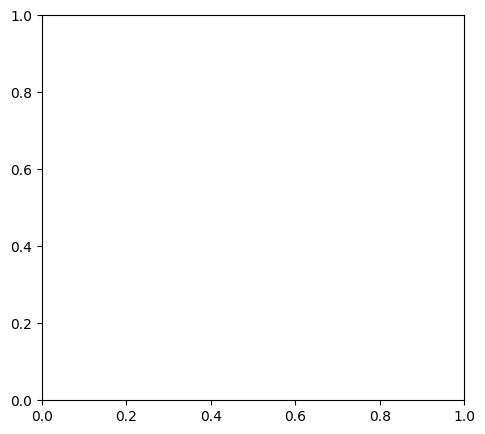

In [12]:
# ## Plot Training and Validation Loss and Accuracy

# %%
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Training Loss')
plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()